# Marker gene heatmap of perturbation data excluding stretch signature - for Fig 6E

In [2]:
%matplotlib inline

import os
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-info">
    
# Navigating this notebook
*** ***
**[Input/Output, Settings, and Upload Data](#in_out)**
0. [Directories](#step0)
1. [Plotting parameters](#plot_params)
2. [Load data](#load_data)
    <br>
    <br>

**[Heatmap](#heatmap_logic)**
2. [Parameters for marker gene visualization](#mg_params)
3. [Choose data and annotation levels (PLEASE READ)](#ann_level)
4. [Identify marker genes and order them by state](#id_mg_order)
5. [Gene filtering](#gene_filt)
6. [Prepare final heatmap - marker genes on any set of annotations](#prep_heatmap)
7. [Plot and save files](#plot_save)
    
</div>  

*** ***

<a id='in_out'></a>

## Input/Output & Upload Data

<a id='step0'></a>

### Directories for input and output data

In [32]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_heatmap'
os.makedirs(plot_dir, exist_ok=True)

<a id='plot_params'></a>

### Plotting parameters

In [33]:
# matplotlib params:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=12)
plt.rcParams['pdf.fonttype'] = 42

# scanpy settings:
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figure

# seaborn
sns.set(context='notebook', style='white', font_scale=1.8)

<a id='load_data'></a>

### Load data

In [34]:
adata = sc.read(f'{h5ad_dir}/adata_merged_annotated_perturbations.h5ad')

*** ***

<a id='heatmap_logic'></a>

## Code to make a heatmap of marker genes for single cell annotations/clusters

### Overall logic

* We may wish to identify marker genes on one level of annotations (A1), but visualize them on another level of annotations (A2)
* We'll select genes if they have max expression in A1 annotations, ranked by max-to-second-max ratio
* We'll filter genes to have no more than N markers per annotation, *and* to have no less than max-to-second-max ratio R
* We will then plot them on A1 annotations
* We will then separately plot them on A2 annotations


<a id='mg_params'></a>

### Parameters for marker gene visualization

In [35]:
# Pseudocount value to use below for log-FC and max:2nd-max ratio
pseudocount = 1 # in units of CP10K

# Minimal acceptable max-2nd-max ratio:
max_2ndmax_ratio_thresh = 1.3

# Maximum number marker genes per state:
max_marker_genes = 150

# False discovery rate for p-value filter:
fdr = 0.05

# How to order the genes:
#gene_order_method = 'max_2ndmax_ratio'
gene_order_method = 'max_median_ratio'

<a id='ann_level'></a>

### Choose data and annotation levels (PLEASE READ)

* In the following, rename your scanpy frame to 'adata'
* In the following 'state' contains the annotation that is used for marker gene detection
* In the place clearly marked under 'final visualization', 'state' and 'treatment verbose' are used for 

**If you wish to change the annotation column and final columns used for visualization, edit the appropriate text below**

In [36]:
# Give a clean name to the data:
adata.obs['state'] = adata.obs['state_coarse_grain']

# Here are the cluster annotations for which we'll identify marker genes:
print(adata.obs['state'].unique())

[Stretch Signature, Secretory, Enterocyte, Tuft, Stem, Enteroendocrine]
Categories (6, object): [Stretch Signature, Secretory, Enterocyte, Tuft, Stem, Enteroendocrine]


In [37]:
adata_all = adata

#### Remove the Stretch Signature cells from the dataset for the marker gene analysis

In [38]:
adata = adata[~adata.obs['state'].isin(['Stretch Signature']),:]

<a id='id_mg_order'></a>

### Identify marker genes and order them by state

*Currently, the ordering of states is not explicitly established - you get what Python gives you*

In [39]:
# Make a dataframe containing centroids:
centroids_df = pd.DataFrame(index=list(adata.raw.var_names))
for state in adata.obs['state'].unique():
    tmp = adata.raw[(adata.obs['state'] == state), : ].X.todense().sum(axis=0)
    centroids_df[state]= np.array(tmp).squeeze()

#normalize centroids to CP10K
for col in centroids_df.columns:
    centroids_df[col] = centroids_df[col]/centroids_df[col].sum()*1e4


In [41]:
centroids_df.to_excel(f'{plot_dir}/centroids_perturbation_data_filtered_genes_ss_cells_excluded.xlsx')

<a id='gene_filt'></a>

### Gene filtering

#### Prepare information for gene filtering

In [42]:
# Rank-sum test on genes
# The p-values from these ranks will be used below as a filtering criteria
# We make no other usage of this function
if False:
    sc.tl.rank_genes_groups(adata, groupby='state', method='wilcoxon')

In [43]:
#create a dataframe with information used for filtering and normalization
centroids_info_df = pd.DataFrame()


# the cluster identity in which the gene is maximally expressed
centroids_info_df['max_state'] = centroids_df.idxmax(axis=1)

# the adjusted p-value for the gene in the max cluster 
centroids_info_df['pvals_adj'] = np.ones(np.shape(centroids_info_df['max_state']))
#for state in centroids_df.columns.unique():
    #centroids_info_df.loc[centroids_info_df['max_state'] == state, 'pvals_adj'] = \
        #adata.uns['rank_genes_groups']['pvals_adj'][state][centroids_info_df['max_state'] == state]
    #print(centroids_info_df.loc[centroids_info_df['max_state'] == state, 'pvals_adj'])
    #print(' ')

# the value of max expression, second max expression, and their ratio (pseudo-count corrected)
# NOTE: SECOND-MAX CALCULATION IS SLOW
centroids_info_df['max_CP10K'] = centroids_df.max(axis=1)
centroids_info_df['sec_max_CP10K'] = centroids_df.apply(lambda row: row.nlargest(2).values[-1], axis=1)
centroids_info_df['max_2nd_ratio'] = (pseudocount + centroids_info_df['max_CP10K']) / \
                                            (pseudocount + centroids_info_df['sec_max_CP10K'])

# Rank genes by their max-to-second-max ratio:
centroids_info_df['max_ratio_rank'] = centroids_info_df['max_2nd_ratio'].rank(ascending=False)

# for plotting - the cluster centroid median value per gene
centroids_info_df['med_CP10K'] = centroids_df.median(axis=1)

# max-median ratio:
centroids_info_df['max_med_ratio'] = (pseudocount+ centroids_info_df['max_CP10K']) / \
                                        (pseudocount+ centroids_info_df['med_CP10K'])


#### Apply filtering criteria

In [44]:
# CURRENTLY NOT DOING P-VALUE FILTERING, BECAUSE THE P-VALUES I HAVE FROM THE SCANPY PACKAGE
# SEEM TO MAKE NO SENSE

# Mask out genes that fail p-value test, by hiding their max-cluster assignment
# The masked-out max-state is stored in a new column, max_state_filt

centroids_info_df['max_state_filt'] = centroids_info_df['max_state']
#centroids_info_df.loc[ centroids_info_df['pvals_adj'] > fdr ,'max_state_filt'] = \
#    'non-significant'

#### Read in stretch signature genes so you can remove them from these marker genes

In [45]:
stretch_response_gene_list_file = open("stretch_response_genes.txt", "r")

stretch_response_gene_list= stretch_response_gene_list_file.readlines()

stretch_response_gene_list_final = []
for gene in stretch_response_gene_list:
    stretch_response_gene_list_final.append(gene.strip("\n"))

In [46]:
# Apply remaining filter criteria to generate gene list
# Gene is max in the cluster
# Gene max-to-2nd-max is above threshold
# No more than max_marker_genes genes

marker_genes_dict = {}
marker_genes_all = []

for state in adata.obs['state'].unique():
    # List of genes that are maximal in the state:
    gl = centroids_info_df.index[(centroids_info_df['max_state_filt']==state)]
    
    # Get the top max_marker_genes from this list, ranked by max-to-second max
    # Using code from https://stackoverflow.com/questions/5807047/efficient-way-to-take-the-minimum-maximum-n-values-and-indices-from-a-matrix-usi
    # First get the lowest values for max_ratio_rank:
    n=len(centroids_info_df['max_ratio_rank'].loc[gl]) # number of genes significantly enriched and max in cluster
    if n > max_marker_genes:
        n=max_marker_genes        
    indices = np.argpartition(centroids_info_df['max_ratio_rank'].loc[gl].values, n-1)[:n]
        
        
    #print(centroids_info_df['max_ratio_rank'].loc[gl][indices])
    
    # Filter this list to eliminate genes that have less than threshold max-to-second max
    #print(centroids_info_df['max_2nd_ratio'].loc[gl][indices])
    indices = indices[centroids_info_df['max_2nd_ratio'].loc[gl][indices]>=max_2ndmax_ratio_thresh]
    #print(centroids_info_df['max_2nd_ratio'].loc[gl][indices])
    #print(' ')
    
    # Now we need the indices in order: (Default is gene_order_method='max_2ndmax_ratio')
    min_elements = centroids_info_df['max_ratio_rank'].loc[gl][indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    #print(centroids_info_df['max_ratio_rank'].loc[gl][ordered_indices])
    #print(centroids_info_df['max_ratio_rank'].loc[gl][ordered_indices].index)        
    if gene_order_method=='max_median_ratio':
        #print('Ordering genes by max-median ratio (pseudocount-adjusted).')
        min_elements = centroids_info_df['max_med_ratio'].loc[gl][indices]
        min_elements_order = (np.argsort(min_elements)).iloc[::-1]
        ordered_indices = indices[min_elements_order]
    
    # Finally, here is the ordered list of gene names:
    gl = centroids_info_df['max_ratio_rank'].loc[gl][ordered_indices].index
    
    # Save this list:
    marker_genes_dict[state] = list((set(list(gl)) - set(stretch_response_gene_list_final)))
    marker_genes_all = marker_genes_all + list(gl)
    #print(gl)



<a id='prep_heatmap'></a>

### Prepare final heatmap - marker genes on any set of annotations

**EDIT THE FOLLOWING TO GET THE PLOT YOU WANT**

* *The code below currently makes a nested-columns dataframe that organizes the data*
    * Top level is state-annotation
    * Inner level is condition/treatment

In [49]:
# Make a dataframe containing centroids for plotting:
plt_centroids_df = pd.DataFrame(index=list(adata_all.raw.var_names))

for state in adata_all.obs['state'].unique():
    for treatment in adata_all.obs['treatment verbose'].unique():
        tmp = adata_all.raw[(adata_all.obs['state'] == state) & \
                        (adata_all.obs['treatment verbose'] == treatment), : ]\
                            .X.todense().sum(axis=0)
        plt_centroids_df[state, treatment]= np.array(tmp).squeeze()

# Make hierarchical columns:
plt_centroids_df.columns = pd.MultiIndex.from_tuples(plt_centroids_df.columns)

#normalize centroids to CP10K
for col in plt_centroids_df.columns:
    plt_centroids_df[col] = plt_centroids_df[col]/plt_centroids_df[col].sum()*1e4



In [50]:
# Now re-make the log fold-change data frame 
#   using same markers, but now for different sets of clusters

# instead of marker genes all - iterate over states, fix vmin vmax, and call 
# logfc marekrs, providing marker genes dict state
# iterate and then save the heatmap every time

# only include the first three columns 
logFC_markers = (pseudocount + plt_centroids_df.loc[marker_genes_all]).divide( \
                pseudocount + centroids_info_df['med_CP10K'].loc[marker_genes_all],axis=0)

logFC_markers = np.log2(logFC_markers)

# Display:
logFC_markers

Stretch Signature                                         Secretory  \
            Forskolin 12h  DMSO 12h CFTR-inh172 36h  DMSO 36h Forskolin 12h   
defa30          -0.694678  0.759652        0.072369 -0.021889      5.743933   
defa24          -0.974882  1.069830       -0.362732 -0.506047      5.534668   
defa17           0.079641  1.457676       -0.161612  0.046998      4.966232   
defa29          -0.273565 -0.181221       -0.392369 -0.117666      4.657621   
gm7861          -0.131168  0.605901       -0.163285  0.023516      4.063493   
...                   ...       ...             ...       ...           ...   
arid1a           0.121786 -0.023503       -0.212611  0.045519     -0.146094   
ube3a            0.288688  0.068549       -0.214118  0.109402     -0.096187   
fbln2            0.040544  0.138360        0.194174  0.114455     -0.028254   
gm36839          0.106803  0.289236       -0.023271  0.000005      0.032508   
tmem57           0.005225  0.301674       -0.049064  0.035471      0.086162   

                                               Enterocyte            ...  \
         DMSO 12h CFTR-inh172 36h  DMSO 36h Forskolin 12h  DMSO 12h  ...   
defa30   5.871615        6.035318  6.023266     -0.117710 -0.821078  ...   
defa24   5.912086        6.018322  5.816424     -0.218779 -1.097076  ...   
defa17   5.729352        5.554964  5.263188     -0.023069 -0.184629  ...   
defa29   5.141134        5.009126  5.297340     -0.302579 -0.365816  ...   
gm7861   4.872633        4.789165  5.010732     -0.069927 -0.089724  ...   
...           ...             ...       ...           ...       ...  ...   
arid1a   0.033972        0.104292 -0.115662      0.146165 -0.044279  ...   
ube3a   -0.074334       -0.280966 -0.062958      0.197947  0.018248  ...   
fbln2   -0.028254       -0.028254  0.007457     -0.000984 -0.002067  ...   
gm36839  0.014283       -0.124735 -0.054116      0.002395  0.119987  ...   
tmem57   0.033544        0.004271 -0.043305      0.004931  0.025265  ...   

                   Tuft                    Stem                            \
        CFTR-inh172 36h  DMSO 36h Forskolin 12h  DMSO 12h CFTR-inh172 36h   
defa30        -0.543831  0.523346     -0.334333 -0.711153       -0.573905   
defa24        -1.045438  0.149065      0.414563 -0.943531       -0.932405   
defa17        -0.766559 -0.239921      0.179743 -0.076614       -0.146134   
defa29        -0.588797 -0.588797     -0.322442 -0.241961       -0.206595   
gm7861        -0.222188  0.304449     -0.064025 -0.115635       -0.068168   
...                 ...       ...           ...       ...             ...   
arid1a         0.100302 -0.031801     -0.037893 -0.075899       -0.030372   
ube3a         -0.583408  0.328196      0.049198 -0.023815       -0.064038   
fbln2         -0.028254 -0.028254      0.052994 -0.028254        0.008776   
gm36839       -0.245699 -0.245699     -0.087535  0.085240       -0.036560   
tmem57        -0.192045 -0.192045     -0.110797 -0.021567       -0.015724   

                  Enteroendocrine                                      
         DMSO 36h   Forskolin 12h  DMSO 12h CFTR-inh172 36h  DMSO 36h  
defa30   0.048783       -0.368945 -0.406648       -0.044999  0.364588  
defa24  -0.443884       -0.886085 -1.154244        0.982651  0.355788  
defa17   0.101031       -0.473870  0.028120       -0.340887  0.220971  
defa29   0.018156       -0.588797 -0.422148       -0.073795  0.255660  
gm7861   0.110278       -0.222188 -0.222188        0.006290  0.081151  
...           ...             ...       ...             ...       ...  
arid1a   0.070662        0.185520  0.426762        0.788881  0.208785  
ube3a    0.041290        0.648963  0.647369        0.015716  0.437778  
fbln2    0.005342        0.507642  0.766425        0.200225  0.328787  
gm36839 -0.025465        0.498259  0.907772        0.432910  0.111342  
tmem57   0.028189        0.733715  0.259333        0.322958  0.407076  

[575 rows x 24 columns]

<a id='plot_save'></a>

### Plot and save files

#### Plot and save the heatmap

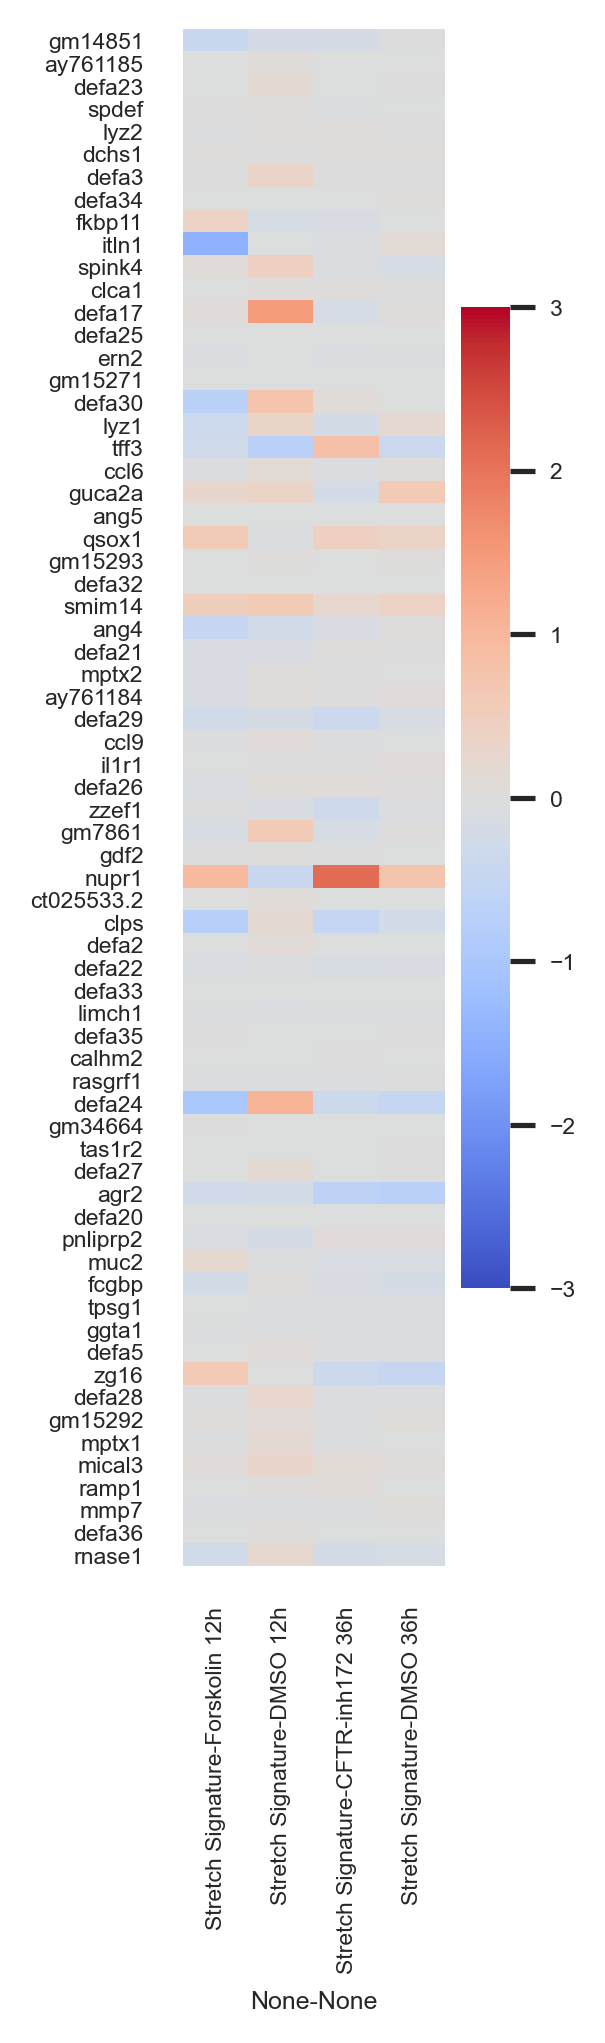

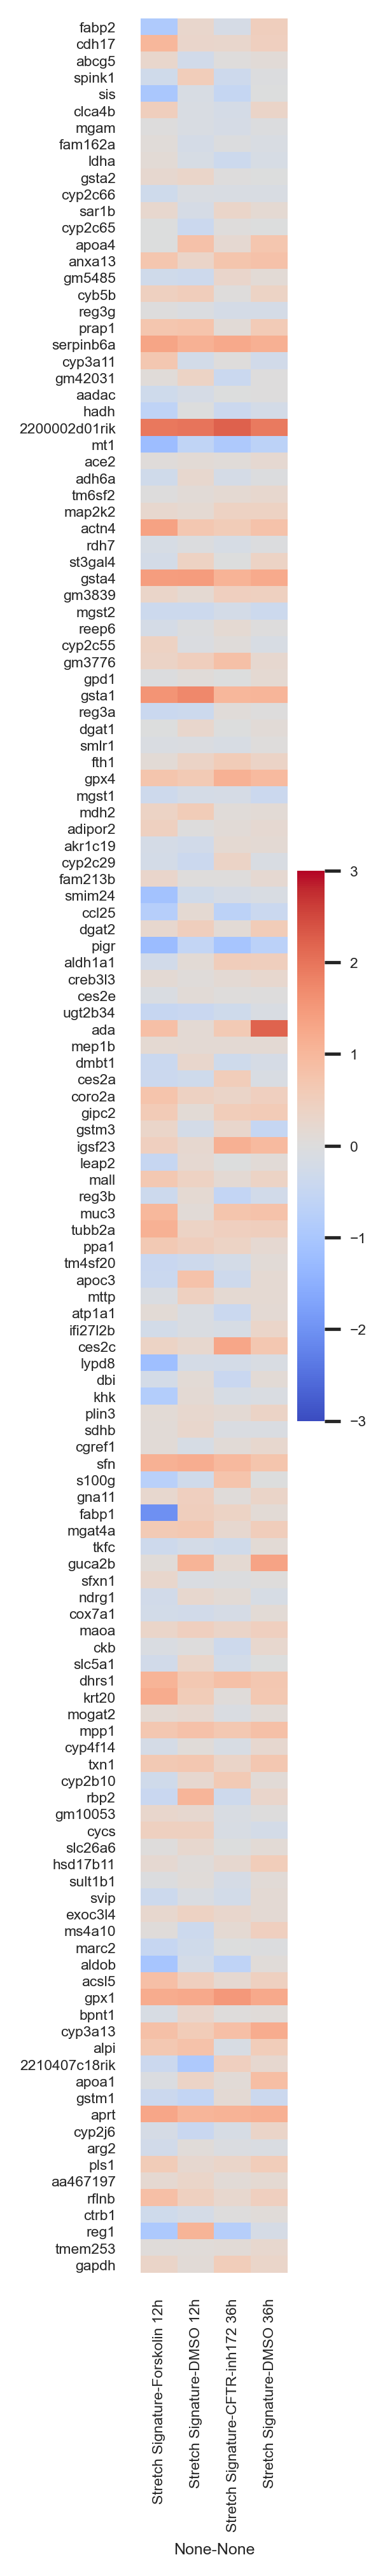

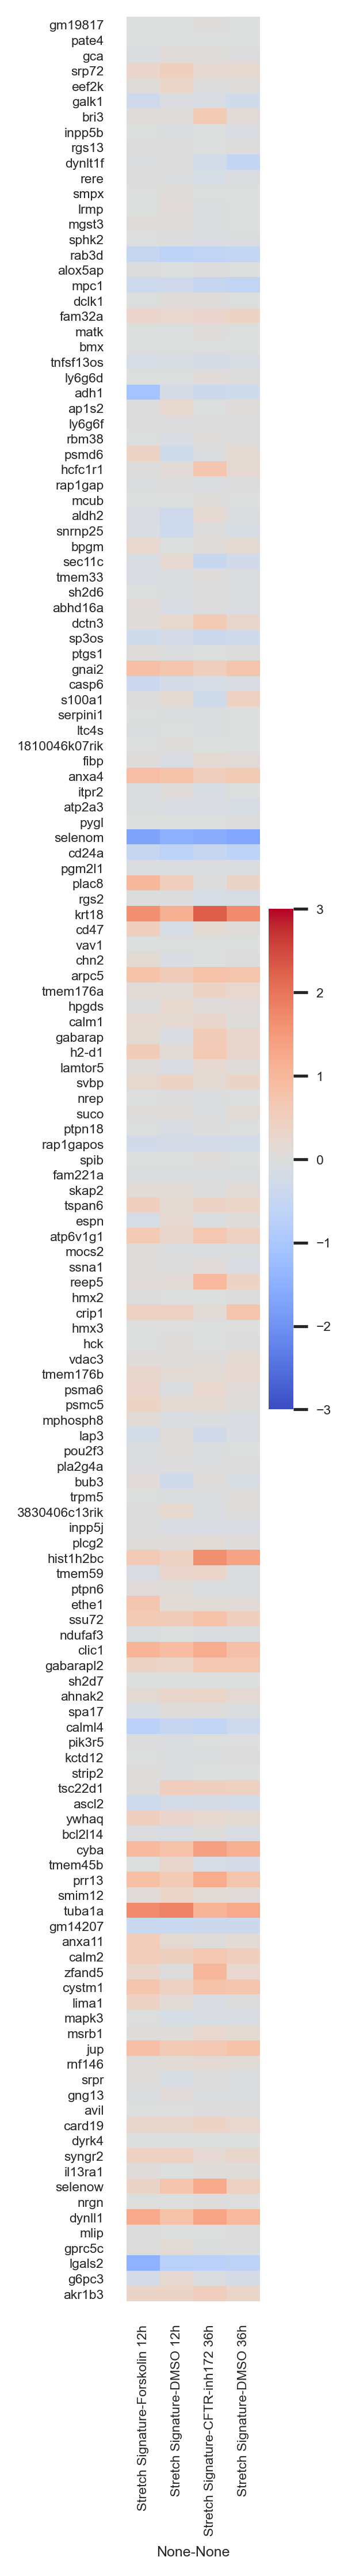

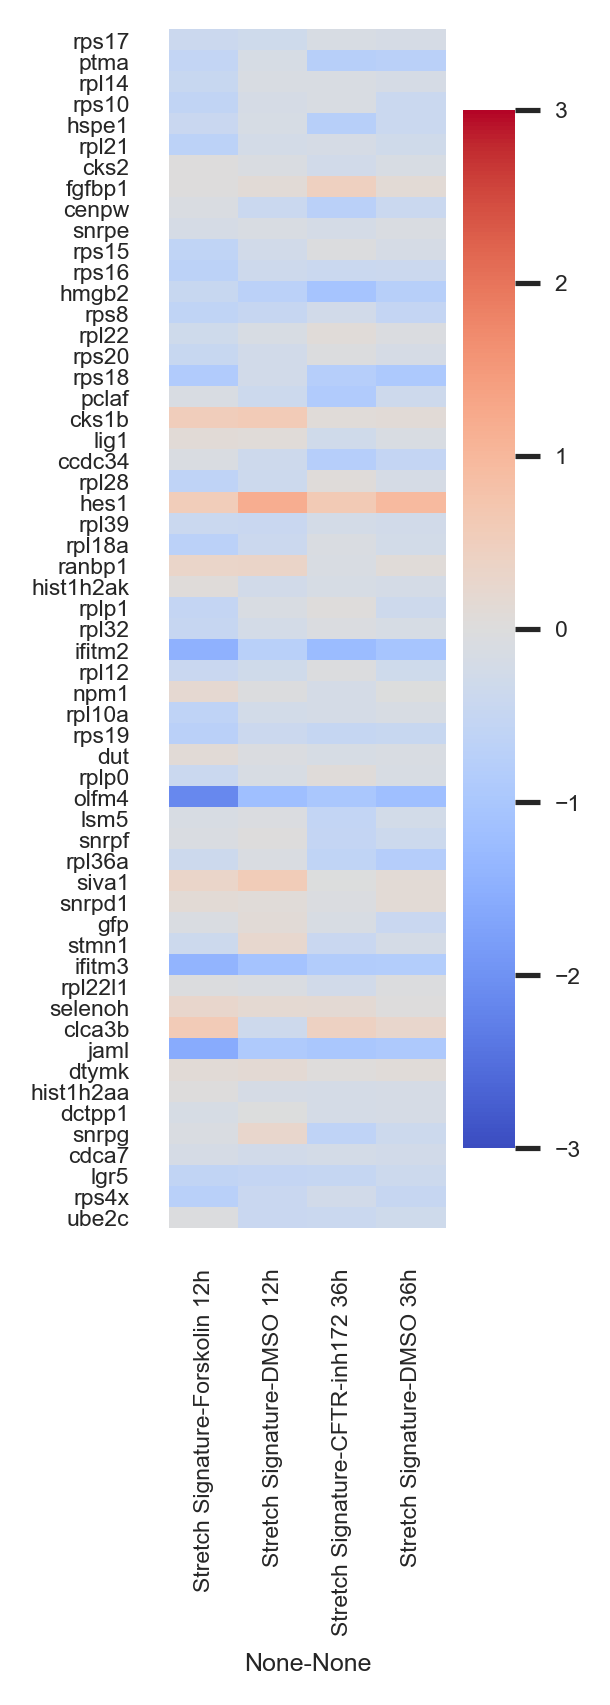

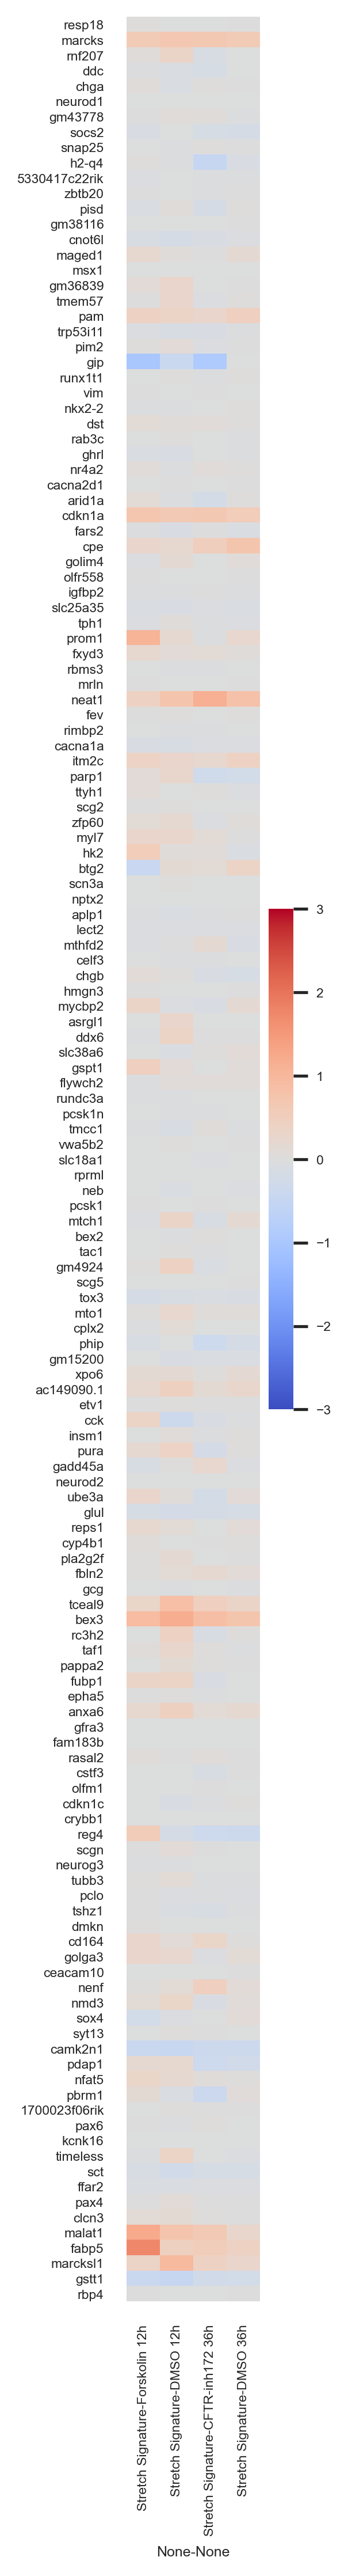

In [52]:
# Now re-make the log fold-change data frame 
#   using same markers, but now for different sets of clusters

# instead of marker genes all - iterate over states, fix vmin vmax, and call 
# logfc marekrs, providing marker genes dict state
# iterate and then save the heatmap every time

# Make and format heatmap:
sns.set(font_scale=0.5)

plot_cell_states = ['Stretch Signature']

new_order_gene_list = []
# The following will generate the plots
for marker_state in marker_genes_dict.keys():
    for gene in marker_genes_dict[marker_state]:
        new_order_gene_list.append(gene)
    plt.figure(figsize = (2,0.1*len(marker_genes_dict[marker_state])) )
    sns.heatmap(logFC_markers[plot_cell_states].loc[marker_genes_dict[marker_state]], cmap='coolwarm',vmin=-3,vmax=+3,xticklabels=1,yticklabels=1)
    plt.tight_layout()
    plt.savefig(f'{plot_dir}/heatmap_genes_by_state_and_condition_perturbations_max150_stretch_sig_cells_only_excl_treatment_verbose_ss_mg{marker_state}_excluding_ss_marker_genes.eps')
    plt.show()



#### Save the heatmap data

In [51]:
logFC_markers.to_excel(f'{plot_dir}/LogFC_CP10K_med_CP10K_norm_psct_1_ss_markers_excluded.xlsx')

#### Save gene list

In [53]:
with open('perturbations_mg_list_mg150_exclude_ss_mg_treatment_verbose.txt', 'w') as f:
    for gene in new_order_gene_list:
        f.write("%s\n" % gene)

### Read in each of the logFC tables with and without stretch signature genes included

In [54]:
logFC_ss_inc = pd.read_excel(f'{plot_dir}/LogFC_CP10K_med_CP10K_norm_psct_1_ss_markers_included.xlsx', header=[0,1], index_col=[0,1])

In [55]:
logFC_ss_exc = pd.read_excel(f'{plot_dir}/LogFC_CP10K_med_CP10K_norm_psct_1_ss_markers_excluded.xlsx', header=[0,1], index_col=[0,1])

In [56]:
frames = [logFC_ss_inc[0:150], logFC_ss_exc]

In [57]:
new_df = pd.concat(frames)

In [58]:
with open('final_order_genes_heatmap_fig6E', 'w') as f:
    for gene in list(new_df.index):
        f.write("%s\n" % gene[0])

In [59]:
new_df.to_excel(f'{plot_dir}/Fig6E_heatmap_values.xlsx')